# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Setup

## Install Libraries

In [1]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [2]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [3]:
from google.colab import files

In [4]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [6]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [7]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [8]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [9]:
def save_plot2png(file_suffix='_plot.png', nodate=True):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
        out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [10]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False)
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

# Get Clean Text

## Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [11]:
# Upload Plain Text File
novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    novel_name_str = fn

# Extract from Dict and decode binary into char string
TEXT_ENCODING = 'utf-8'  # Define the encoding format
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)

BOOK_FILENAME_AUTHOR = novel_name_str.split('.')[0]
BOOK_FILENAME_AUTHOR

Saving book_the-great-gatsby_fsfitzgerald.txt to book_the-great-gatsby_fsfitzgerald.txt
User uploaded file "book_the-great-gatsby_fsfitzgerald.txt" with length 286442 bytes


'book_the-great-gatsby_fsfitzgerald'

In [12]:
# Verify

verify_novel(novel_raw_str)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 276892

Beginning:

                               Once again
                                  to
                                 Zelda


  Then wear the gold hat, if that will move her;
  If you can bounce high, bounce for her too,
  Till she cry “Lover, gold-hatted, high-bouncing lover,
  I must have you!”

  Thomas Parke d’Invilliers


                                  I

In my younger and more vulnerable years my father gave me some advice
that I’ve been turning over in my mind ever since.

“



------------------------------------
Ending:

 hardly fail to grasp it. He
did not know that it was already behind him, somewhere back in that
vast obscurity beyond the city, where the dark fields of the republic
rolled on under the night.

Gatsby believed in the green light, the orgastic future that year by
year recedes before us. It eluded us then, but that’s no
matter—tomorrow we will run faster, stretch out our arms furthe

## Clean Text

In [13]:
!pip install clean-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=2b2126e2ab091a2935a66f11726a2e14f80c312dd774ab9ab57750913d902ee3
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [14]:
!pip install unidecode  # clean-text dependency

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.8 MB/s eta 0:00:00


In [15]:
from cleantext import clean

In [16]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that. in consequence, i\'m inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores. the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person, and so it came about that in college i was unjustly accused of being a politician, bec

In [17]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 268671

Beginning:

 once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d'invilliers i in my younger and more vulnerable years my father gave me some advice that i've been turning over in my mind ever since. "whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven't had the advantages that you've had." he didn't say an



------------------------------------
Ending:

 he could hardly fail to grasp it. he did not know that it was already behind him, somewhere back in that vast obscurity beyond the city, where the dark fields of the republic rolled on under the night. gatsby believed in the green light, the orgastic future that year by year recedes before us. it eluded us then, but that's no matter--tomorrow we will run faster, 

## Trim Text

In [18]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [19]:
!pip install pysbd  # Python Sentence Boundry Detection

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 3.8 MB/s eta 0:00:00


In [20]:
import pysbd

In [21]:
# FIX: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [22]:
%%time

# NOTE:  1m05s animal farm
#       11m22s harry potter
#        2m13s jane eyre

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
# novel_segments_ls = seg.segment(novel_trim_str)
novel_segments_ls = [segment for segment in tqdm(seg.segment(novel_trim_str), desc="Segmenting Novel")]

Segmenting Novel: 100%|██████████| 1357/1357 [00:00<00:00, 1762672.82it/s]

CPU times: user 40.5 s, sys: 131 ms, total: 40.6 s
Wall time: 54.6 s


In [23]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [24]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_the-great-gatsby_fsfitzgerald.txt
  Char Len: 1357

Beginning:

 ['once again to zelda then wear the gold hat, if that will move her; if you can bounce high, bounce for her too, till she cry "lover, gold-hatted, high-bouncing lover, i must have you!" thomas parke d\'invilliers i in my younger and more vulnerable years my father gave me some advice that i\'ve been turning over in my mind ever since.', '"whenever you feel like criticizing anyone," he told me, "just remember that all the people in this world haven\'t had the advantages that you\'ve had." he didn\'t say any more, but we\'ve always been unusually communicative in a reserved way, and i understood that he meant a great deal more than that.', "in consequence, i'm inclined to reserve all judgements, a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores.", 'the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal per

In [25]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_the-great-gatsby_fsfitzgerald_segments.txt

STEP 3. Downloading permanent copy of textfile: book_the-great-gatsby_fsfitzgerald_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
sentiment_df

pandas.core.frame.DataFrame

In [27]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

1356

,line_no,line
0,0,"once again to zelda then wear the gold hat, if..."
1,1,"""whenever you feel like criticizing anyone,"" h..."
2,2,"in consequence, i'm inclined to reserve all ju..."
3,3,the abnormal mind is quick to detect and attac...
4,4,most of the confidences were unsought--frequen...


# Compute Sentiment

## Option (1): Symbolic: Lexicons

### VADER

In [28]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.7 MB/s eta 0:00:00


In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [30]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [31]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['sentiment'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,sentiment
0,0,"once again to zelda then wear the gold hat, if...",0.5572
1,1,"""whenever you feel like criticizing anyone,"" h...",0.7265
2,2,"in consequence, i'm inclined to reserve all ju...",-0.2732
3,3,the abnormal mind is quick to detect and attac...,-0.2960
4,4,most of the confidences were unsought--frequen...,0.3797


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'VADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_vader_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_vader_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

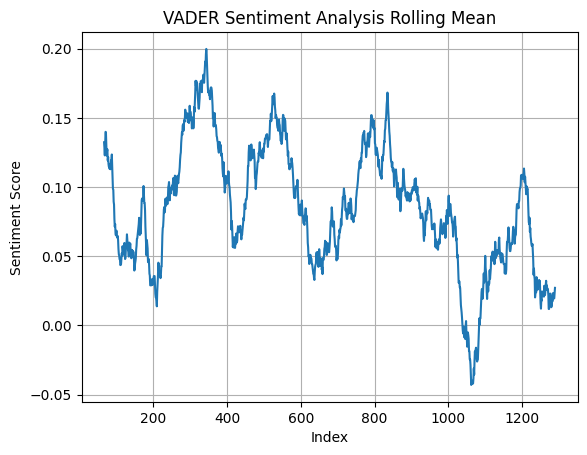

In [32]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

_ = vader_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("VADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_vader_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [33]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### TextBlob

In [34]:
from textblob import TextBlob

In [35]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [36]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [37]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['sentiment'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,sentiment
0,0,"once again to zelda then wear the gold hat, if...",0.050000
1,1,"""whenever you feel like criticizing anyone,"" h...",0.500000
2,2,"in consequence, i'm inclined to reserve all ju...",0.085000
3,3,the abnormal mind is quick to detect and attac...,0.016667
4,4,most of the confidences were unsought--frequen...,-0.050744


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'TextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_textblob_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_textblob_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

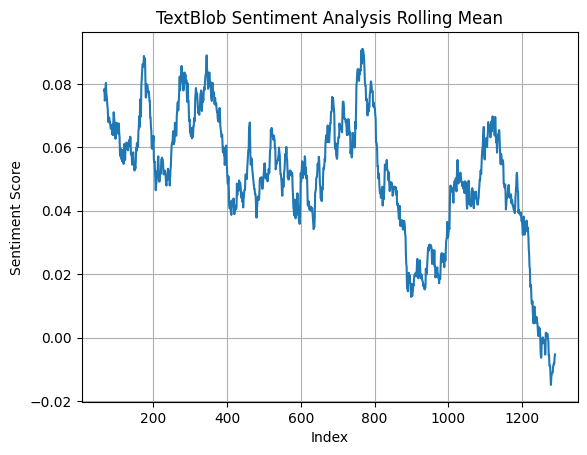

In [38]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

_ = textblob_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("TextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_textblob_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [39]:
# Save TextBlob Model Sentiment Time Series

save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SyuzhetR (4)

* SyzuhetR: https://cran.r-project.org/web/packages/readtext/vignettes/readtext_vignette.html
* http://rstudio-pubs-static.s3.amazonaws.com/283881_efbb666d653a4eb3b0c5e5672e3446c6.html

* SentimentR: https://github.com/trinker/sentimentr

* JupyterLab w/Py OR R: https://www.youtube.com/watch?v=Q35WIqZoUF4

In [40]:
%load_ext rpy2.ipython

In [41]:
# Load Python libraries to exchange data with R Program Space and read R Datafiles

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [42]:
%R getwd()

'/content'


In [43]:
%R list.files()

'book_the...,'book_the...,'book_the...,...,'book_the...,'book_the...,'sample_d...


In [44]:
%%time
%%capture
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 56s 17:30EST on 27Oct2022 - Colab Pro

install.packages(c('sentimentr'))

library(sentimentr)

(as ‘lib’ is unspecified)
































































	‘/tmp/Rtmpq5iRhC/downloaded_packages’



CPU times: user 3.69 s, sys: 260 ms, total: 3.95 s
Wall time: 1min 21s


In [45]:
%%time
%%capture
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 56s 17:30EST on 27Oct2022 - Colab Pro

install.packages(c('syuzhet', 'sentimentr', 'tidyverse', 'lexicon'))

library(syuzhet)
library(sentimentr)
library(tidyverse)
library(lexicon)

(as ‘lib’ is unspecified)






















	‘/tmp/Rtmpq5iRhC/downloaded_packages’

Attaching package: ‘syuzhet’



    get_sentences


Attaching package: ‘lexicon’



    available_data




CPU times: user 2.1 s, sys: 113 ms, total: 2.21 s
Wall time: 26.6 s


In [46]:
%R sessionInfo()

<rpy2.robjects.vectors.ListVector object at 0x7e659ff19d80> [RTYPES.VECSXP]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
<rpy2.robjects.vectors.ListVector object at 0x7e659ff19d80> [RTYPES.VECSXP]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e659ffe2a40> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64-pc-linux-gnu']
  locale: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e65a01ee580> [RTYPES.STRSXP]
R classes: ('character',)
['LC_CTYPE=en_US.UTF-8;LC_NUMERIC=C;LC_TIME=en_US....]
  tzone: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e659ff7d100> [RTYPES.STRSXP]
R classes: ('character',)
['Etc/UTC']
...
  running: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e65a01c6700> [RTYPES.STRSXP]
R classes: ('character',)
['default']
  RNGkind: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e65a004ba40> [RTYPES.STRSXP]
R classes: ('character',)
['/usr/lib/x86_64-linux-gnu/openblas-pthread/libbl...]
  basePkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e65a00487c0> [RTYPES.STRSXP]
R classes: ('character',)
['/usr/lib/x86_64-linux-gnu/openblas-pthread/libla...]
  otherPkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7e65a0049840> [RTYPES.STRSXP]
R classes: ('character',)
['3.10.0']

In [47]:
sentiment_df.head()

,line_no,line
0,0,"once again to zelda then wear the gold hat, if..."
1,1,"""whenever you feel like criticizing anyone,"" h..."
2,2,"in consequence, i'm inclined to reserve all ju..."
3,3,the abnormal mind is quick to detect and attac...
4,4,most of the confidences were unsought--frequen...


In [48]:
%%time

# Compute Sentiments from all 4 Syuzhet Models

# NOTE:  3m57s 17:40EST on 27Oct2022 Colab Pro (The Idiot)
#        3m55s 18:02EST on 27Oct2022 Colab Pro (The Idiot)
#        4m10s 23:14EST on 27Oct2022 Colab Pro (The Idiot)

syuzhet = importr('syuzhet')

# Create new SyuzhetR DataFrame to save results
syuzhet_df = sentiment_df[['line_no', 'line']].copy(deep=True)

print('[1/4] Processing syuzhetr_syuzhet')
syuzhet_df['syuzhetr_syuzhet'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='syuzhet')
print('[2/4] Processing syuzhetr_bing')
syuzhet_df['syuzhetr_bing'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='bing')
print('[3/4] Processing syuzhetr_afinn')
syuzhet_df['syuzhetr_afinn'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='afinn')
print('[4/4] Processing syuzhetr_nrc')
syuzhet_df['syuzhetr_nrc'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='nrc')

syuzhet_df.head()

[1/4] Processing syuzhetr_syuzhet
[2/4] Processing syuzhetr_bing
[3/4] Processing syuzhetr_afinn
[4/4] Processing syuzhetr_nrc
CPU times: user 3.96 s, sys: 97.2 ms, total: 4.06 s
Wall time: 4.09 s


,line_no,line,syuzhetr_syuzhet,syuzhetr_bing,syuzhetr_afinn,syuzhetr_nrc
0,0,"once again to zelda then wear the gold hat, if...",0.00,0,-1,1.0
1,1,"""whenever you feel like criticizing anyone,"" h...",1.50,1,5,2.0
2,2,"in consequence, i'm inclined to reserve all ju...",0.55,-1,-2,1.0
3,3,the abnormal mind is quick to detect and attac...,-3.90,-4,0,-4.0
4,4,most of the confidences were unsought--frequen...,2.65,0,-2,5.0


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Syuzhet Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_syzhet_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_syzhet_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

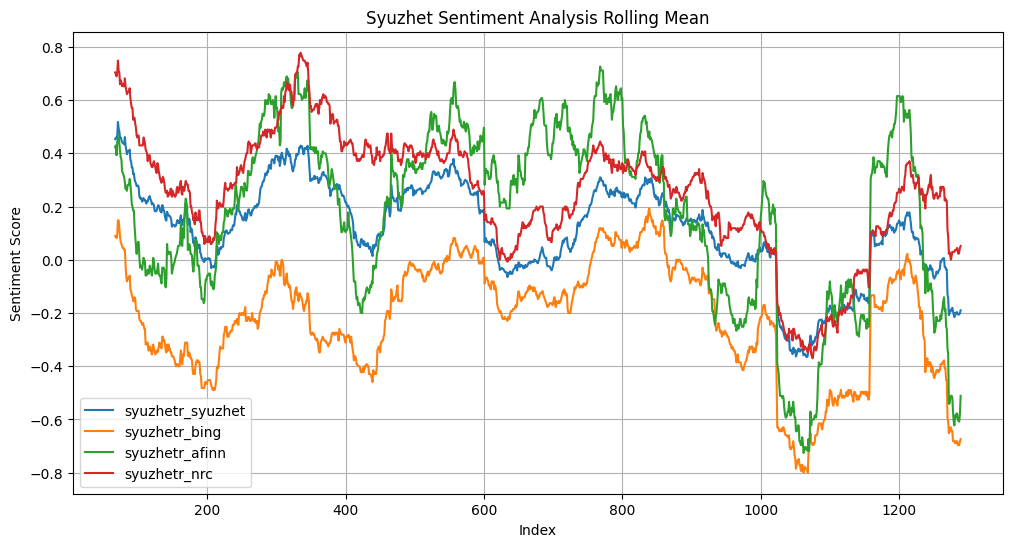

In [49]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * syuzhet_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
syuzhet_model_ls = ['syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']
_ = syuzhet_df[syuzhet_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("Syuzhet Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_syzhet_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [50]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(syuzhet_df, '_syuzhetr_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SentimentR (8)

Call function in external get_sentimentr.R from within Python Loop

* https://medium.com/analytics-vidhya/calling-r-from-python-magic-of-rpy2-d8cbbf991571

* https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

In [51]:
%%file get_sentimentr.R

library(sentimentr)
library(lexicon)

get_sentimentr_values <- function(s_v) {

  print('[1/8] Processing sentimentr_jockersrinker')
  sentimentr_jockersrinker <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers_rinker,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[2/8] Processing sentimentr_jockers')
  sentimentr_jockers <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[3/8] Processing sentimentr_huliu')
  sentimentr_huliu <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_huliu,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[4/8] Processing sentimentr_nrc')
  sentimentr_nrc <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_nrc,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[5/8] Processing sentimentr_senticnet')
  sentimentr_senticnet <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_senticnet,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[6/8] Processing sentimentr_sentiword')
  sentimentr_sentiword <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_sentiword,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[7/8] Processing sentimentr_loughran_mcdonald')
  sentimentr_loughran_mcdonald <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_loughran_mcdonald,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[8/8] Processing sentimentr_socal_google')
  sentimentr_socal_google <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_socal_google,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  anovel_sentimentr_df <- data.frame(# 'text_clean' = s_v,
                                'sentimentr_jockersrinker' = sentimentr_jockersrinker$sentiment,
                                'sentimentr_jockers' = sentimentr_jockers$sentiment,
                                'sentimentr_huliu' = sentimentr_huliu$sentiment,
                                'sentimentr_nrc' = sentimentr_nrc$sentiment,
                                'sentimentr_senticnet' = sentimentr_senticnet$sentiment,
                                'sentimentr_sentiword' = sentimentr_sentiword$sentiment,
                                'sentimentr_loughran_mcdonald' = sentimentr_loughran_mcdonald$sentiment,
                                'sentimentr_socal_google' = sentimentr_socal_google$sentiment
                                )
  return(anovel_sentimentr_df)

}

Writing get_sentimentr.R


In [52]:
# Verify the *.R file above was written correctly

# !cat get_sentimentr.R

In [53]:
# Setup python robject with external library::function()
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

# import rpy2.robjects as robjects

# Defining the R script and loading the instance in Python
# from rpy2.robjects import pandas2ri
r = robjects.r

# Loading the function we have defined in R.
r['source']('get_sentimentr.R')

# Reading and processing data
get_sentimentr_function_r = robjects.globalenv['get_sentimentr_values']

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [54]:
%%time

# NOTE:   2m40s  @17:48EST on 27Oct2022 Colab Pro (The Idiot)
#         2m42s  @18:06EST on 27Oct2022 Colab Pro (The Idiot)
#         2m37s  @23:20EST on 27Oct2022 Colab Pro (The Idiot)

# Call external get_sentimentr::get_sentimentr_values with Python loop over all novels

line_ls = sentiment_df['line'].to_list()

# Convert Python List of Strings to a R vector of characters
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html
sentence_v = robjects.StrVector(line_ls)
sentiment_df_r = get_sentimentr_function_r(sentence_v)

# Convert rpy2.robjects.vectors.DataFrame to pandas.core.frame.DataFrame
# https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
print(f'type(sentiment_df_r): {type(sentiment_df_r)}')
temp_df = pd.DataFrame.from_dict({ key : np.asarray(sentiment_df_r.rx2(key)) for key in sentiment_df_r.names })
print(f'type(temp_df): {type(temp_df)}')

# Create new SentimentR DataFrame to save results
# sentimentr_df = sentiment_df[['line_no', 'line']].copy(deep=True)
sentimentr_df = pd.DataFrame()

# This works for Novels New Corpus Texts
sentimentr_df['sentimentr_jockersrinker'] = temp_df['sentimentr_jockersrinker']
sentimentr_df['sentimentr_jockers'] = temp_df['sentimentr_jockers']
sentimentr_df['sentimentr_huliu'] = temp_df['sentimentr_huliu']
sentimentr_df['sentimentr_nrc'] = temp_df['sentimentr_nrc']
sentimentr_df['sentimentr_senticnet'] = temp_df['sentimentr_senticnet']
sentimentr_df['sentimentr_sentiword'] = temp_df['sentimentr_sentiword']
sentimentr_df['sentimentr_loughran_mcdonald'] = temp_df['sentimentr_loughran_mcdonald']
sentimentr_df['sentimentr_socal_google'] = temp_df['sentimentr_socal_google']

sentimentr_df.head()

[1] "[1/8] Processing sentimentr_jockersrinker"
[1] "[2/8] Processing sentimentr_jockers"
[1] "[3/8] Processing sentimentr_huliu"
[1] "[4/8] Processing sentimentr_nrc"
[1] "[5/8] Processing sentimentr_senticnet"
[1] "[6/8] Processing sentimentr_sentiword"
[1] "[7/8] Processing sentimentr_loughran_mcdonald"
[1] "[8/8] Processing sentimentr_socal_google"
type(sentiment_df_r): <class 'rpy2.robjects.vectors.DataFrame'>
type(temp_df): <class 'pandas.core.frame.DataFrame'>
CPU times: user 25.4 s, sys: 66 ms, total: 25.5 s
Wall time: 26.7 s


,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google
0,0.275000,0.275000,0.633333,0.466667,1.005533,-0.217014,0.00000,0.247375
1,-0.086603,-0.086603,-0.346410,0.346410,0.143568,0.072169,-0.34641,-0.275919
2,-0.150000,-0.150000,-0.200000,0.000000,0.728000,0.164583,-0.40000,0.000000
3,0.259808,0.259808,-0.086603,0.779423,0.389298,0.049315,0.34641,0.000000
4,0.382559,0.346638,0.035921,0.323290,0.260033,0.218894,0.00000,-0.004495


In [55]:
# prompt: for sentiment_df, insert 'line_no" as the first column that assigns sequentially increasing integers from 0 upward, drop the index

# Assuming sentiment_df is your DataFrame
sentimentr_df = sentimentr_df.reset_index(drop=True)
sentimentr_df.insert(0, 'line_no', range(0, len(sentimentr_df)))
sentimentr_df.head()

,line_no,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google
0,0,0.275000,0.275000,0.633333,0.466667,1.005533,-0.217014,0.00000,0.247375
1,1,-0.086603,-0.086603,-0.346410,0.346410,0.143568,0.072169,-0.34641,-0.275919
2,2,-0.150000,-0.150000,-0.200000,0.000000,0.728000,0.164583,-0.40000,0.000000
3,3,0.259808,0.259808,-0.086603,0.779423,0.389298,0.049315,0.34641,0.000000
4,4,0.382559,0.346638,0.035921,0.323290,0.260033,0.218894,0.00000,-0.004495


In [56]:
sentimentr_df.columns.to_list()

['line_no',
 'sentimentr_jockersrinker',
 'sentimentr_jockers',
 'sentimentr_huliu',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_sentiword',
 'sentimentr_loughran_mcdonald',
 'sentimentr_socal_google']

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'SentimentR Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

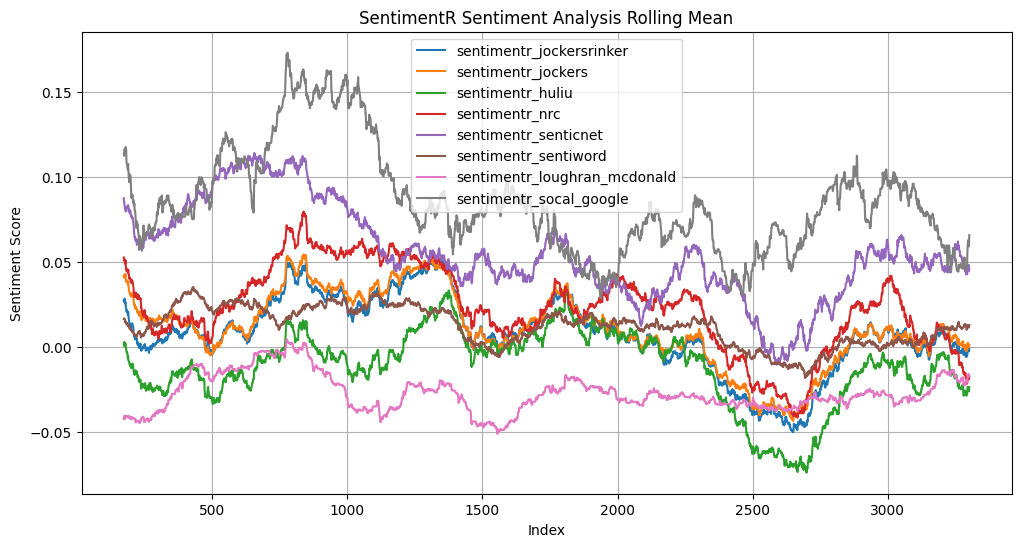

In [57]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * sentimentr_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
sentimentr_model_ls = [
    'sentimentr_jockersrinker',
    'sentimentr_jockers',
    'sentimentr_huliu',
    'sentimentr_nrc',
    'sentimentr_senticnet',
    'sentimentr_sentiword',
    'sentimentr_loughran_mcdonald',
    'sentimentr_socal_google']
_ = sentimentr_df[sentimentr_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("SentimentR Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_sentimentr_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [58]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(sentimentr_df, '_sentimentr_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Option (2): Statistical ML

* https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0

In [59]:
# Example: Naive Bayes

# https://www.datacamp.com/tutorial/simplifying-sentiment-analysis-python

In [60]:
# Example: SVM

# https://www.kaggle.com/code/bansodesandeep/sentiment-analysis-support-vector-machine

## Option (3): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [61]:
!pip install -q transformers

In [62]:
!pip install sentencepiece

In [63]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [73]:
from transformers import TrainingArguments

In [64]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [65]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [66]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [74]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [76]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [69]:
# import wandb

# wandb.init() # wandb.log()

In [77]:
%%time

# NOTE: Must click on output LINK, get wandb API_KEY, and paste it in text input box

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 19.5 s, sys: 110 ms, total: 19.6 s
Wall time: 21.2 s


In [78]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [80]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [81]:
line_no_ls = list(range(len(sentiment_ls)))

In [82]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,"once again to zelda then wear the gold hat, if...",1,POSITIVE,0.995641
1,1,"""whenever you feel like criticizing anyone,"" h...",1,POSITIVE,0.960773
2,2,"in consequence, i'm inclined to reserve all ju...",1,POSITIVE,0.920143
3,3,the abnormal mind is quick to detect and attac...,0,NEGATIVE,0.988105
4,4,most of the confidences were unsought--frequen...,0,NEGATIVE,0.951712


In [83]:
distilbert_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'DistilBERT Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

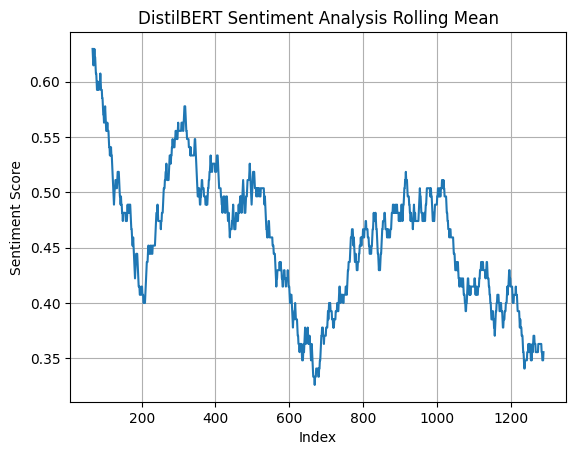

In [84]:
win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("DistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_distilbert_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [85]:
# Save Model Sentiment Time Series

save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [86]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [108]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [109]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [110]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [112]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 2min 3s, sys: 278 ms, total: 2min 3s
Wall time: 2min 14s


In [113]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [114]:
line_no_ls = list(range(len(sentiment_ls)))

In [115]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,"once again to zelda then wear the gold hat, if...",1,POSITIVE,0.995791
1,1,"""whenever you feel like criticizing anyone,"" h...",1,POSITIVE,0.997030
2,2,"in consequence, i'm inclined to reserve all ju...",1,POSITIVE,0.991612
3,3,the abnormal mind is quick to detect and attac...,0,NEGATIVE,0.990941
4,4,most of the confidences were unsought--frequen...,0,NEGATIVE,0.989568


In [116]:
nlptown_df.shape

(1357, 5)

In [117]:
nlptown_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'NLPTown Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

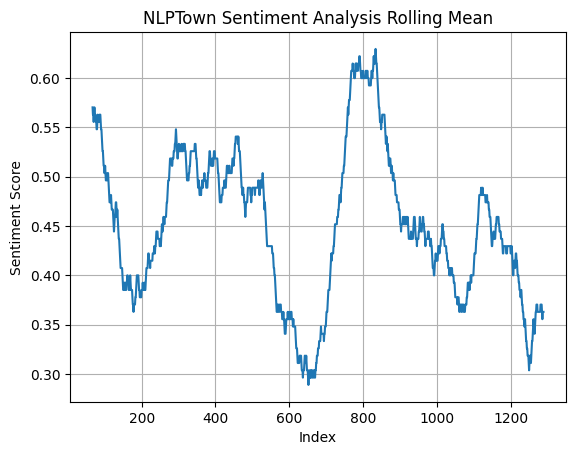

In [118]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("NLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_nlptown_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [119]:
# Save Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [120]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
# trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [121]:
# Create training arguments with wandb disabled
training_args = TrainingArguments(
    output_dir="./results",
    report_to=[],  # This disables wandb logging
)

# Initialize trainer with the arguments
trainer = Trainer(
    model=model,
    args=training_args,
)

In [122]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [123]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 2min 11s, sys: 251 ms, total: 2min 11s
Wall time: 2min 14s


In [124]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [125]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [126]:
line_no_ls = list(range(len(sentiment_ls)))

In [127]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,"once again to zelda then wear the gold hat, if...",1,POSITIVE,0.995791
1,1,"""whenever you feel like criticizing anyone,"" h...",1,POSITIVE,0.997030
2,2,"in consequence, i'm inclined to reserve all ju...",1,POSITIVE,0.991612
3,3,the abnormal mind is quick to detect and attac...,0,NEGATIVE,0.990941
4,4,most of the confidences were unsought--frequen...,0,NEGATIVE,0.989568


In [128]:
roberta15lg_df['label'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'RoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

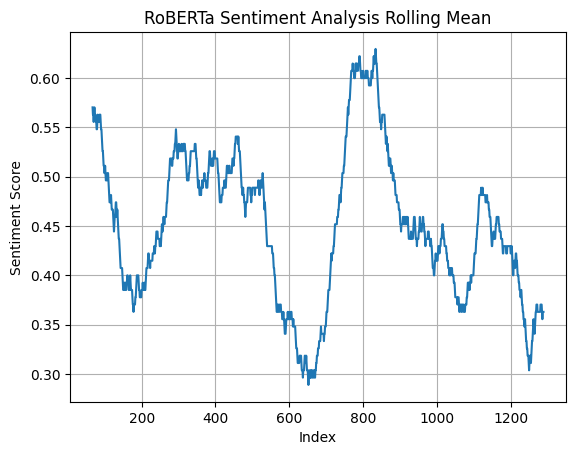

In [129]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [130]:
# Save Model Sentiment Time Series

save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [131]:
!ls -altr

total 3272
drwxr-xr-x 4 root root   4096 Nov  6 14:23 .config
drwxr-xr-x 1 root root   4096 Nov  6 14:23 sample_data
drwxr-xr-x 1 root root   4096 Nov  8 12:09 ..
-rw-r--r-- 1 root root 286442 Nov  8 12:17 book_the-great-gatsby_fsfitzgerald.txt
-rw-r--r-- 1 root root 268780 Nov  8 12:18 book_the-great-gatsby_fsfitzgerald_segments.txt
-rw-r--r-- 1 root root  45348 Nov  8 12:18 book_the-great-gatsby_fsfitzgerald_vader_sentiment_plot.png
-rw-r--r-- 1 root root 288085 Nov  8 12:18 book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
-rw-r--r-- 1 root root  46485 Nov  8 12:18 book_the-great-gatsby_fsfitzgerald_textblob_sentiment_plot.png
-rw-r--r-- 1 root root 294438 Nov  8 12:18 book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv
-rw-r--r-- 1 root root 149311 Nov  8 12:20 book_the-great-gatsby_fsfitzgerald_syzhet_sentiment_plot.png
-rw-r--r-- 1 root root 300374 Nov  8 12:20 book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv
-rw-r--r-- 1 root root   3711 Nov  8 12:20 get_sent

In [132]:
def clean_filenames_with_max_n(substr_del_template=' ({n})'):
    # Regex pattern to match the substring pattern " ({n})" where n is any integer
    pattern = re.compile(r' \((\d+)\)')

    # Dictionary to store filenames with their highest "n" value
    files_to_keep = {}

    # Iterate over all files in the current directory
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            # Extract the number and the root filename (without the " (n)" part and the extension)
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # Keep only the file with the highest "n" value for each base filename
            if base_filename not in files_to_keep or n_value > files_to_keep[base_filename][1]:
                files_to_keep[base_filename] = (filename, n_value)

    # Delete files that are not the one with the highest "n" value
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # If the current file is not the one to keep, delete it
            if filename != files_to_keep[base_filename][0]:
                print(f"Deleting file: {filename}")
                os.remove(filename)
            else:
                # Rename the kept file to remove the " (n)" part
                new_name = base_filename
                if filename != new_name:
                    print(f"Renaming {filename} to {new_name}")
                    os.rename(filename, new_name)

# Run the function
clean_filenames_with_max_n()


In [134]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "the-great-gatsby_fscottfitzgerald")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the pattern
        csv_filename = f'book_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list




In [106]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

# BOOK_FILENAME_AUTHOR = 'book_animal-farm_gorwell'
# BOOK_FILENAME_AUTHOR = 'book_harry-potter-and-the-order-of-the-phoenix_jkrowlings'
# BOOK_FILENAME_AUTHOR = 'book_jane-eyre_cbronte'
# BOOK_FILENAME_AUTHOR = novel_name_str

In [136]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR)
print(csv_list)

Looking for files with title_author: the-great-gatsby_fsfitzgerald
['book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv', 'book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv']


In [137]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: the-great-gatsby_fsfitzgerald
book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv
book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv
book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv
book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv
book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv
book_the-great-gatsby_fsfitzgerald_roberta15lg_sentiment.csv


In [ ]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [138]:
sentimentr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475 entries, 0 to 3474
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line_no                       3475 non-null   int64  
 1   sentimentr_jockersrinker      3475 non-null   float64
 2   sentimentr_jockers            3475 non-null   float64
 3   sentimentr_huliu              3475 non-null   float64
 4   sentimentr_nrc                3475 non-null   float64
 5   sentimentr_senticnet          3475 non-null   float64
 6   sentimentr_sentiword          3475 non-null   float64
 7   sentimentr_loughran_mcdonald  3475 non-null   float64
 8   sentimentr_socal_google       3475 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 244.5 KB


In [139]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)



book_the-great-gatsby_fsfitzgerald_vader_sentiment.csv
Index(['line_no', 'line', 'sentiment'], dtype='object')


book_the-great-gatsby_fsfitzgerald_textblob_sentiment.csv
Index(['line_no', 'line', 'sentiment'], dtype='object')


book_the-great-gatsby_fsfitzgerald_syuzhetr_sentiment.csv
Index(['line_no', 'line', 'syuzhetr_syuzhet', 'syuzhetr_bing',
       'syuzhetr_afinn', 'syuzhetr_nrc'],
      dtype='object')


book_the-great-gatsby_fsfitzgerald_sentimentr_sentiment.csv
Index(['line_no', 'sentimentr_jockersrinker', 'sentimentr_jockers',
       'sentimentr_huliu', 'sentimentr_nrc', 'sentimentr_senticnet',
       'sentimentr_sentiword', 'sentimentr_loughran_mcdonald',
       'sentimentr_socal_google'],
      dtype='object')


book_the-great-gatsby_fsfitzgerald_distilbert_sentiment.csv
Index(['line_no', 'line', 'distilbert', 'label', 'score'], dtype='object')


book_the-great-gatsby_fsfitzgerald_nlptown_sentiment.csv
Index(['line_no', 'line', 'nlptown', 'label', 'score'], dtype='object

In [140]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'sentiment']
Model #1: sentiment
 Cols: ['line_no', 'line', 'syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']
Model #2: sentiment
 Cols: ['line_no', 'sentimentr_jockersrinker', 'sentimentr_jockers', 'sentimentr_huliu', 'sentimentr_nrc', 'sentimentr_senticnet', 'sentimentr_sentiword', 'sentimentr_loughran_mcdonald', 'sentimentr_socal_google']
Model #3: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #4: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #5: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']



## **[START HERE IF UPLOADING PREPROCESSED SENTIMENT_ALL_DF *.csv]**

In [ ]:
# OPTIONAL: prompt: upload a *.csv file into sentiment_all_df pandas dataframe

# SKIP if executing from start

from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Assuming the uploaded file is a CSV
  sentiment_all_df = pd.read_csv(io.BytesIO(uploaded[fn]))

  # Now you can work with the dataframe 'sentiment_all_df'
  print(sentiment_all_df.head())

In [141]:
sentiment_all_df.head()

,line_no,line,sentiment_x,sentiment_y,syuzhetr_syuzhet,syuzhetr_bing,syuzhetr_afinn,syuzhetr_nrc,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google,distilbert,nlptown,roberta15lg
0,0,"once again to zelda then wear the gold hat, if...",0.5572,0.050000,0.00,0,-1,1.0,0.275000,0.275000,0.633333,0.466667,1.005533,-0.217014,0.00000,0.247375,1,1,1
1,1,"""whenever you feel like criticizing anyone,"" h...",0.7265,0.500000,1.50,1,5,2.0,-0.086603,-0.086603,-0.346410,0.346410,0.143568,0.072169,-0.34641,-0.275919,1,1,1
2,2,"in consequence, i'm inclined to reserve all ju...",-0.2732,0.085000,0.55,-1,-2,1.0,-0.150000,-0.150000,-0.200000,0.000000,0.728000,0.164583,-0.40000,0.000000,1,1,1
3,3,the abnormal mind is quick to detect and attac...,-0.2960,0.016667,-3.90,-4,0,-4.0,0.259808,0.259808,-0.086603,0.779423,0.389298,0.049315,0.34641,0.000000,0,0,0
4,4,most of the confidences were unsought--frequen...,0.3797,-0.050744,2.65,0,-2,5.0,0.382559,0.346638,0.035921,0.323290,0.260033,0.218894,0.00000,-0.004495,0,0,0


In [142]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line_no                       1357 non-null   int64  
 1   line                          1357 non-null   object 
 2   sentiment_x                   1357 non-null   float64
 3   sentiment_y                   1357 non-null   float64
 4   syuzhetr_syuzhet              1357 non-null   float64
 5   syuzhetr_bing                 1357 non-null   int64  
 6   syuzhetr_afinn                1357 non-null   int64  
 7   syuzhetr_nrc                  1357 non-null   float64
 8   sentimentr_jockersrinker      1357 non-null   float64
 9   sentimentr_jockers            1357 non-null   float64
 10  sentimentr_huliu              1357 non-null   float64
 11  sentimentr_nrc                1357 non-null   float64
 12  sentimentr_senticnet          1357 non-null   float64
 13  sen

In [143]:
# prompt: save sentiment_all_df as f"{BOOK_FILENAME_AUTHOR}_sentiment_all.csv" and then download

sentiment_all_df.to_csv(f"{BOOK_FILENAME_AUTHOR}_sentiment_all.csv", index=False)
files.download(f"{BOOK_FILENAME_AUTHOR}_sentiment_all.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [144]:
  import matplotlib.pyplot as plt
  import seaborn as sns
  from scipy import stats
  import numpy as np
  import pandas as pd

In [145]:
def plot_all(sentiment_all_df, save_plots=True):
    """
    Plot all sentiment columns after z-score normalization, using SMA smoothing.
    Window size is 10% of series length, with 5% edge extrapolation.
    Includes mean of all series in black.

    Parameters:
    sentiment_all_df (pd.DataFrame): DataFrame containing sentiment columns and line_no
    save_plots (bool): If True, saves plots as PNG files
    """


    # Create a copy to avoid modifying the original dataframe
    df = sentiment_all_df.copy()

    # Get all columns except line_no
    sentiment_cols = [col for col in df.columns if col != 'line_no']

    # Convert columns to numeric, dropping any that can't be converted
    numeric_cols = []
    for col in sentiment_cols:
        try:
            df[col] = pd.to_numeric(df[col])
            numeric_cols.append(col)
        except (ValueError, TypeError):
            print(f"Warning: Dropping column '{col}' as it contains non-numeric values")
            continue

    if not numeric_cols:
        raise ValueError("No numeric columns found for plotting")

    # Calculate window size (10% of series length)
    window_size = max(3, int(len(df) * 0.1))
    # Calculate extrapolation size (5% of series length)
    extrap_size = int(len(df) * 0.05)

    # Create figure with appropriate size
    plt.figure(figsize=(15, 8))

    # Store smoothed series for calculating mean
    all_smoothed = []
    base_linewidth = 1.5  # Base line width for individual series

    # Plot each sentiment column after z-normalization and smoothing
    for col in numeric_cols:
        # Z-normalize the column
        z_scores = stats.zscore(df[col], nan_policy='omit')

        # Create series for smoothing
        series = pd.Series(z_scores)

        # Extrapolate edges before smoothing
        start_values = series[:extrap_size].values[::-1]
        end_values = series[-extrap_size:].values[::-1]

        # Create extended series
        extended_series = pd.concat([
            pd.Series(start_values),
            series,
            pd.Series(end_values)
        ])

        # Apply SMA
        smoothed = extended_series.rolling(window=window_size, center=True).mean()

        # Trim back to original size
        smoothed = smoothed[extrap_size:-extrap_size]

        # Store smoothed series for mean calculation
        all_smoothed.append(smoothed)

        # Plot with some transparency for better visibility when lines overlap
        plt.plot(df['line_no'], smoothed, label=col, alpha=0.7, linewidth=base_linewidth)

    # Calculate and plot mean of all series
    mean_series = pd.concat(all_smoothed, axis=1).mean(axis=1)
    plt.plot(df['line_no'], mean_series, label='Mean of All', color='black',
             alpha=0.7, linewidth=base_linewidth*2)

    # Customize the plot
    plt.title(f'Z-normalized Sentiment Analysis Comparison\n(SMA window: {window_size} lines, {extrap_size} lines extrapolated at edges)',
              fontsize=14)
    plt.xlabel('Line Number', fontsize=12)
    plt.ylabel('Z-normalized Sentiment Score', fontsize=12)

    # Add legend with smaller font and outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
              fontsize=10, borderaxespad=0.)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()

    # Save the plot if requested
    if save_plots:
        plt.savefig('sentiment_analysis_comparison.png',
                    dpi=300,
                    bbox_inches='tight')

    # Show the plot
    plt.show()
    plt.close()

    # Print basic statistics and create correlation heatmap
    print("\nCorrelation between different sentiment analyses:")
    correlation_matrix = df[numeric_cols].corr()

    # Use seaborn to create a heatmap of correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Sentiment Analyses', fontsize=14)
    plt.tight_layout()

    # Save the correlation heatmap if requested
    if save_plots:
        plt.savefig('correlation_heatmap.png',
                    dpi=300,
                    bbox_inches='tight')

    plt.show()
    plt.close()

    # Print mean absolute differences between normalized scores
    print("\nMean absolute differences between normalized scores:")
    z_scores_df = df[numeric_cols].apply(lambda x: stats.zscore(x, nan_policy='omit'))

    for i, col1 in enumerate(numeric_cols):
        for col2 in numeric_cols[i+1:]:
            mad = abs(z_scores_df[col1] - z_scores_df[col2]).mean()
            print(f"{col1} vs {col2}: {mad:.3f}")

    return df[numeric_cols]  # Return the numeric columns for further analysis if needed

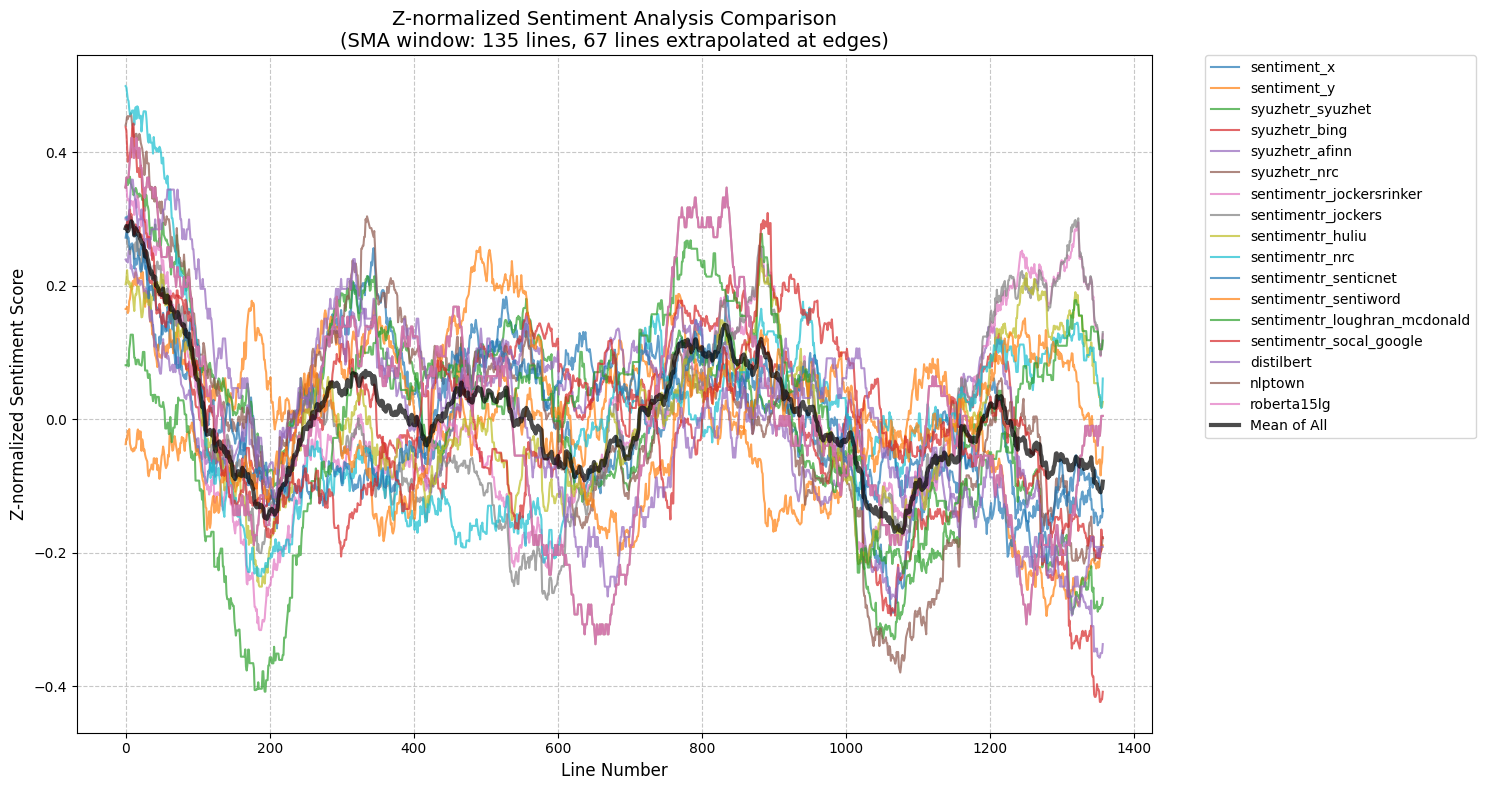


Correlation between different sentiment analyses:


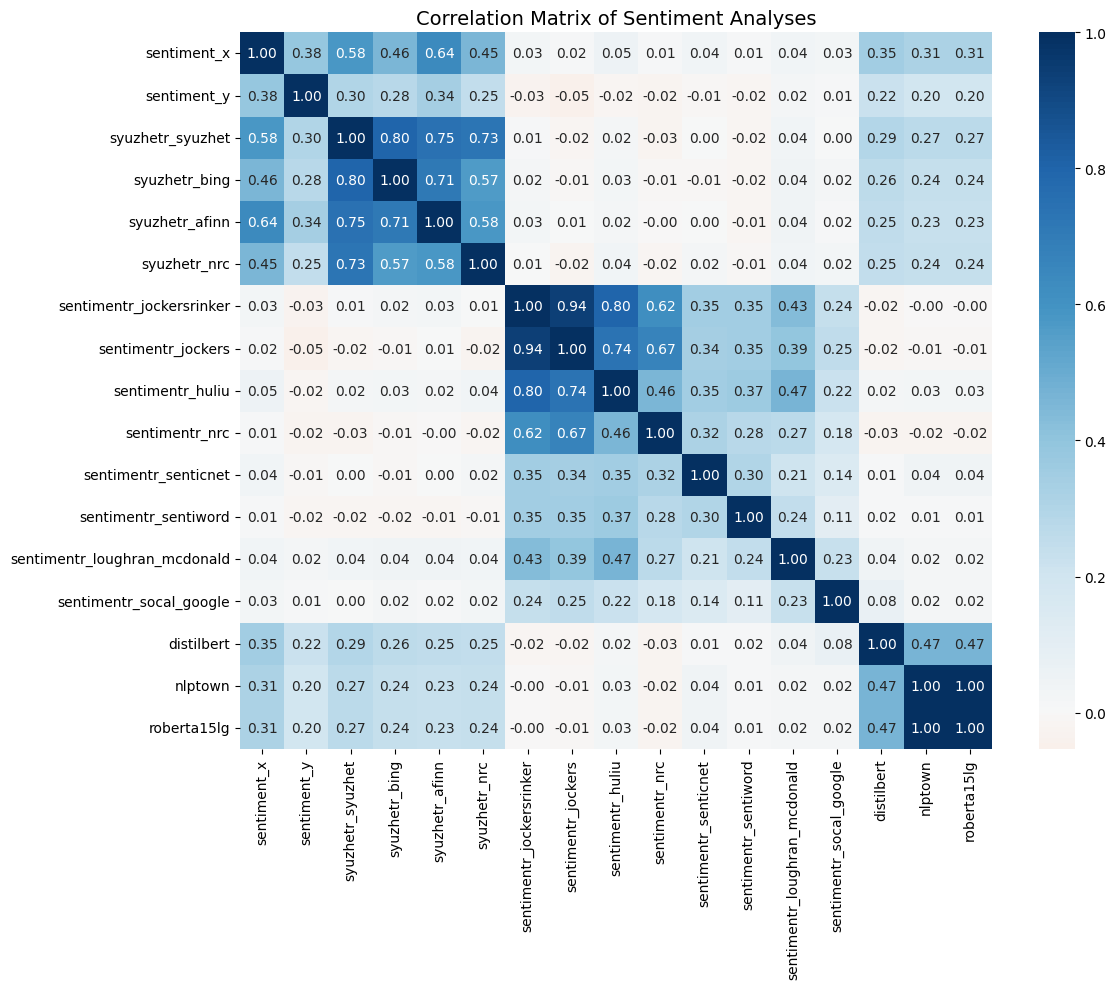


Mean absolute differences between normalized scores:
sentiment_x vs sentiment_y: 0.848
sentiment_x vs syuzhetr_syuzhet: 0.612
sentiment_x vs syuzhetr_bing: 0.701
sentiment_x vs syuzhetr_afinn: 0.544
sentiment_x vs syuzhetr_nrc: 0.743
sentiment_x vs sentimentr_jockersrinker: 1.095
sentiment_x vs sentimentr_jockers: 1.095
sentiment_x vs sentimentr_huliu: 1.075
sentiment_x vs sentimentr_nrc: 1.082
sentiment_x vs sentimentr_senticnet: 1.098
sentiment_x vs sentimentr_sentiword: 1.102
sentiment_x vs sentimentr_loughran_mcdonald: 1.056
sentiment_x vs sentimentr_socal_google: 1.035
sentiment_x vs distilbert: 0.928
sentiment_x vs nlptown: 0.953
sentiment_x vs roberta15lg: 0.953
sentiment_y vs syuzhetr_syuzhet: 0.799
sentiment_y vs syuzhetr_bing: 0.812
sentiment_y vs syuzhetr_afinn: 0.779
sentiment_y vs syuzhetr_nrc: 0.860
sentiment_y vs sentimentr_jockersrinker: 1.078
sentiment_y vs sentimentr_jockers: 1.085
sentiment_y vs sentimentr_huliu: 1.060
sentiment_y vs sentimentr_nrc: 1.052
sentiment_

In [148]:
# Plot with sentiment analysis
plot_all(sentiment_all_df)

In [149]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357 entries, 0 to 1356
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line_no                       1357 non-null   int64  
 1   line                          1357 non-null   object 
 2   sentiment_x                   1357 non-null   float64
 3   sentiment_y                   1357 non-null   float64
 4   syuzhetr_syuzhet              1357 non-null   float64
 5   syuzhetr_bing                 1357 non-null   int64  
 6   syuzhetr_afinn                1357 non-null   int64  
 7   syuzhetr_nrc                  1357 non-null   float64
 8   sentimentr_jockersrinker      1357 non-null   float64
 9   sentimentr_jockers            1357 non-null   float64
 10  sentimentr_huliu              1357 non-null   float64
 11  sentimentr_nrc                1357 non-null   float64
 12  sentimentr_senticnet          1357 non-null   float64
 13  sen

In [150]:
# Add download commands for Colab

files.download('sentiment_analysis_comparison.png')
files.download('correlation_heatmap.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Crux Detection and Extraction

In [151]:
from google.colab import files

In [152]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, argrelextrema
from statsmodels.nonparametric.smoothers_lowess import lowess
import textwrap
import matplotlib.pyplot as plt

## Smooth Plots and Add Crux Points

In [153]:
def get_sentiment_mean(df):
    """Same as before"""
    sentiment_cols = [col for col in df.columns
                     if col not in ['line', 'line_no']]
    return df[sentiment_cols].mean(axis=1).tolist()


def detect_peaks_valleys(smoothed_series, peak_algo='find_peaks', peak_algo_params=None):
    """
    Detect peaks and valleys using specified algorithm.

    Args:
        smoothed_series (list): Smoothed and normalized time series
        peak_algo (str): Peak detection algorithm ('find_peaks', 'relmax', 'threshold')
        peak_algo_params (dict): Parameters for the chosen algorithm

    Returns:
        dict: Dictionary with 'peaks' and 'valleys' indices
    """
    series = np.array(smoothed_series)

    # Default parameters for each algorithm
    default_params = {
        'find_peaks': {
            'distance': 20,
            'prominence': 0.1
        },
        'relmax': {
            'order': 10
        },
        'threshold': {
            'threshold': 0.5,
            'min_dist': 20
        }
    }

    params = peak_algo_params if peak_algo_params is not None else default_params[peak_algo]

    if peak_algo == 'find_peaks':
        peaks, _ = find_peaks(series,
                            distance=params['distance'],
                            prominence=params['prominence'])
        valleys, _ = find_peaks(-series,
                              distance=params['distance'],
                              prominence=params['prominence'])

    elif peak_algo == 'relmax':
        peaks = argrelextrema(series, np.greater,
                            order=params['order'])[0]
        valleys = argrelextrema(series, np.less,
                              order=params['order'])[0]

    elif peak_algo == 'threshold':
        peaks = []
        valleys = []
        min_dist = params['min_dist']
        threshold = params['threshold']

        for i in range(1, len(series)-1):
            if peaks and i - peaks[-1] < min_dist:
                continue
            if valleys and i - valleys[-1] < min_dist:
                continue

            if (series[i] > series[i-1] + threshold and
                series[i] > series[i+1] + threshold):
                peaks.append(i)
            elif (series[i] < series[i-1] - threshold and
                  series[i] < series[i+1] - threshold):
                valleys.append(i)

    else:
        raise ValueError(f"Peak detection algorithm '{peak_algo}' not implemented. "
                        "Use 'find_peaks', 'relmax', or 'threshold'.")

    return {
        'peaks': peaks.tolist() if isinstance(peaks, np.ndarray) else peaks,
        'valleys': valleys.tolist() if isinstance(valleys, np.ndarray) else valleys
    }

def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Plot peaks with green dashed lines
    y_min, y_max = plt.ylim()
    text_y = y_max + 0.05 * (y_max - y_min)

    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='bottom', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='bottom', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    return crux_points_dt  # Return detected points for further analysis

def smooth_ts(time_series, method='sma', smooth_param='0.1'):
    """Same as before"""
    series = np.array(time_series)

    if method == 'sma':
        window = max(3, int(float(smooth_param) * len(series)))
        if window % 2 == 0:
            window += 1
        pad_size = window // 2
        padded_series = np.pad(series, (pad_size, pad_size), mode='edge')
        smoothed = np.convolve(padded_series, np.ones(window)/window, mode='valid')

    elif method == 'lowess':
        x = np.arange(len(series))
        smoothed = lowess(
            series,
            x,
            frac=float(smooth_param),
            return_sorted=False
        )
    else:
        raise ValueError(f"Smoothing method '{method}' not implemented. Use 'sma' or 'lowess'.")

    smoothed_min = np.min(smoothed)
    smoothed_max = np.max(smoothed)
    smoothed_normalized = 2 * (smoothed - smoothed_min) / (smoothed_max - smoothed_min) - 1

    return smoothed_normalized.tolist()

In [159]:
def plot_cruxes(book_name, sentiment_mean_ls, sentiment_mean_smooth_ls,
                peak_algo='find_peaks', peak_algo_params=None, SIMPLE=False):
    """
    Plot sentiment analysis with marked crux points.

    Args:
        book_name (str): Name of the book being analyzed
        sentiment_mean_ls (list): Original sentiment values
        sentiment_mean_smooth_ls (list): Smoothed sentiment values
        peak_algo (str): Peak detection algorithm to use
        peak_algo_params (dict): Parameters for peak detection
        SIMPLE (bool): If True, only plot smoothed series with crux lines
    """
    # Detect peaks and valleys
    crux_points_dt = detect_peaks_valleys(sentiment_mean_smooth_ls,
                                        peak_algo=peak_algo,
                                        peak_algo_params=peak_algo_params)

    plt.figure(figsize=(15, 8))

    x = range(len(sentiment_mean_ls))

    if not SIMPLE:
        plt.plot(x, sentiment_mean_ls, 'lightgray', label='Original', alpha=0.5)

    plt.plot(x, sentiment_mean_smooth_ls, 'blue', label='Smoothed', linewidth=2)

    # Get plot limits before adding lines
    plt.draw()  # Force computation of data limits
    y_min, y_max = plt.ylim()

    # Calculate vertical center position for labels
    # text_y = (y_min + y_max) / 2
    text_y = y_min + 0.9 * (y_max - y_min)  # Position at 90% of the vertical height

    # Plot peaks with green dashed lines
    for peak in crux_points_dt['peaks']:
        plt.axvline(x=peak, color='green', linestyle='--', alpha=0.5)
        plt.text(peak, text_y, f'line {peak}',
                rotation=90, va='center', ha='center')

    # Plot valleys with red dashed lines
    for valley in crux_points_dt['valleys']:
        plt.axvline(x=valley, color='red', linestyle='--', alpha=0.5)
        plt.text(valley, text_y, f'line {valley}',
                rotation=90, va='center', ha='center')

    # Customize plot
    plt.title(f'Sentiment Analysis: {book_name}\nPeak Detection: {peak_algo}')
    plt.xlabel('Line Number')
    plt.ylabel('Sentiment Score')

    if SIMPLE:
        plt.legend(['Normalized Sentiment',
                   'Peak Lines', 'Valley Lines'])
    else:
        plt.legend()

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Save plot
    plt.savefig(f'{book_name}_sentiment_plot_{peak_algo}.png',
                dpi=300, bbox_inches='tight')
    plt.close()

    return crux_points_dt  # Return detected points for further analysis

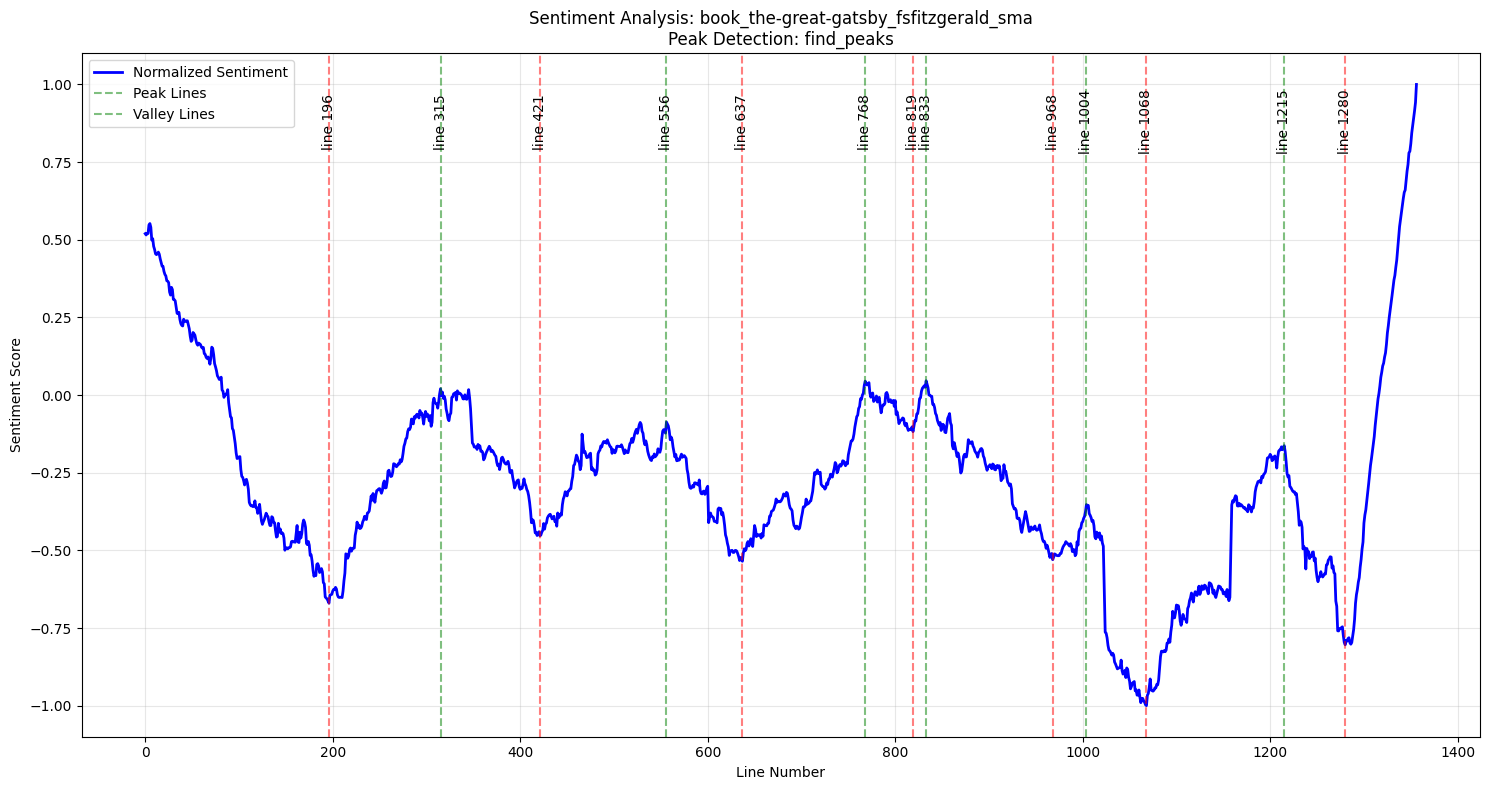

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

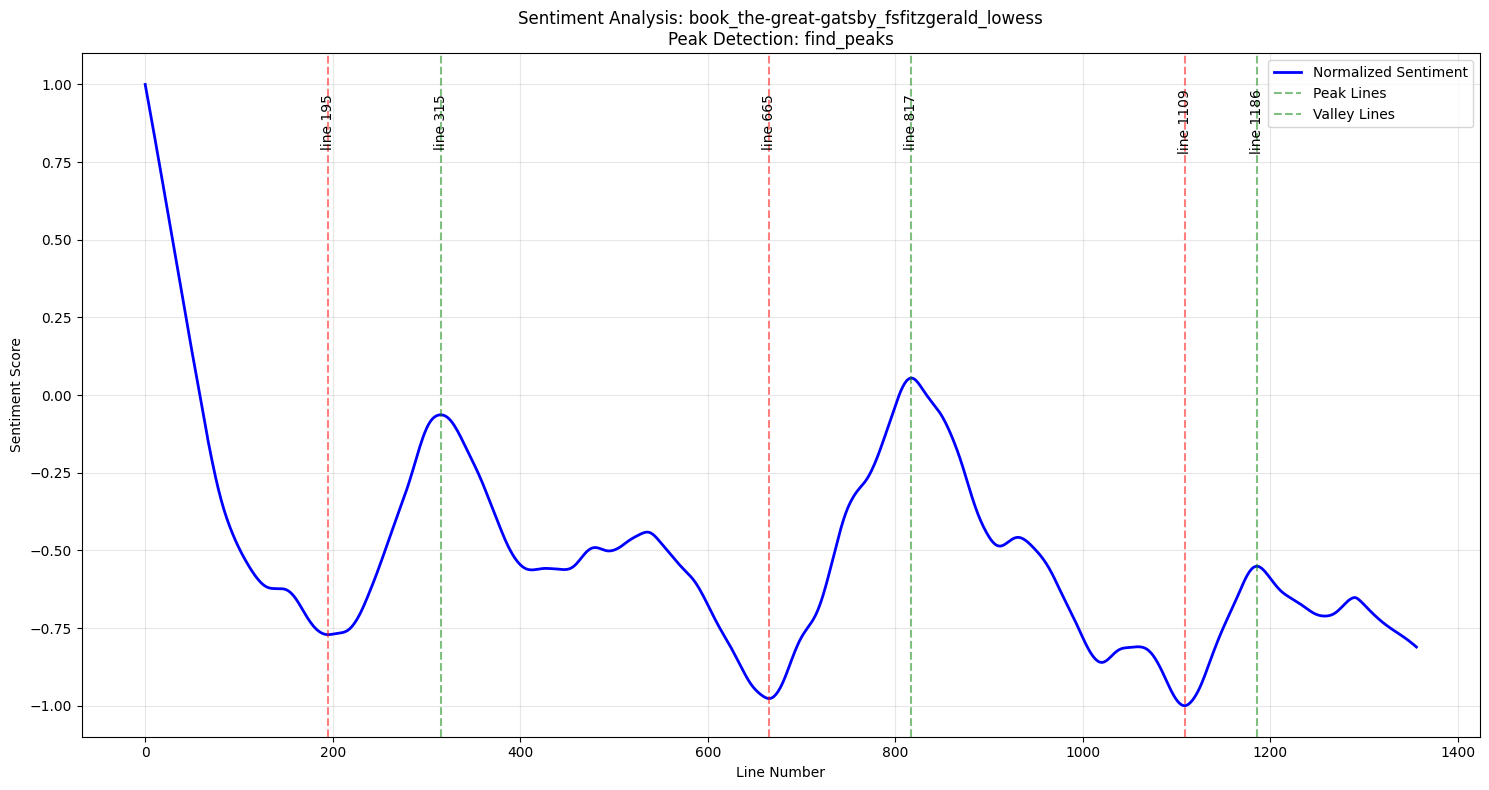

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
# 1. Calculate mean sentiment across all columns
sentiment_mean_ls = get_sentiment_mean(sentiment_all_df)

# 2. Create both SMA and LOWESS smoothed versions
smoothed_sma = smooth_ts(sentiment_mean_ls, method='sma', smooth_param='0.1')
smoothed_lowess = smooth_ts(sentiment_mean_ls, method='lowess', smooth_param='0.1')

# 3. Set up peak detection parameters (optional)
peak_params = {
    'distance': 30,
    'prominence': 0.15
}

# 4. Generate plots for both smoothing methods
# 4a. SMA plot
crux_points_sma = plot_cruxes(
    BOOK_FILENAME_AUTHOR + "_sma",
    sentiment_mean_ls,
    smoothed_sma,
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)
# Download SMA plot
files.download(f'{BOOK_FILENAME_AUTHOR}_sma_sentiment_plot_find_peaks.png')

# 4b. LOWESS plot
crux_points_lowess = plot_cruxes(
    BOOK_FILENAME_AUTHOR + "_lowess",
    sentiment_mean_ls,
    smoothed_lowess,
    peak_algo='find_peaks',
    peak_algo_params=peak_params,
    SIMPLE=True
)
# Download LOWESS plot
files.download(f'{BOOK_FILENAME_AUTHOR}_lowess_sentiment_plot_find_peaks.png')

## Generate Crux Reports

In [155]:
def get_crux_text(df, smoothed_series, peak_algo='find_peaks', peak_algo_params=None, win=21):
    """
    Extract text surrounding crux points with sentiment values. Center line is uppercased.

    Args:
        df (pd.DataFrame): Input dataframe
        smoothed_series (list): Smoothed time series
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
        win (int): Window size for text extraction (odd number)

    Returns:
        tuple: Dictionaries for peaks and valleys text with sentiment
    """
    # Use detect_peaks_valleys instead of get_crux_points
    crux_points_dt = detect_peaks_valleys(smoothed_series, peak_algo, peak_algo_params)

    half_win = win // 2
    peaks_dict = {}
    valleys_dict = {}

    def extract_window_text(center_idx, sentiment_val):
        start_idx = max(0, center_idx - half_win)
        end_idx = min(len(df), center_idx + half_win + 1)

        text_lines = df['line'].iloc[start_idx:end_idx].tolist()
        center_relative_idx = center_idx - start_idx
        if 0 <= center_relative_idx < len(text_lines):
            text_lines[center_relative_idx] = text_lines[center_relative_idx].upper()

        return [sentiment_val, text_lines]

    for peak in crux_points_dt['peaks']:
        sentiment_val = smoothed_series[peak]
        peaks_dict[peak] = extract_window_text(peak, sentiment_val)

    for valley in crux_points_dt['valleys']:
        sentiment_val = smoothed_series[valley]
        valleys_dict[valley] = extract_window_text(valley, sentiment_val)

    return peaks_dict, valleys_dict

def make_crux_report(book_name, smoothed_series, df, peak_algo='find_peaks',
                    peak_algo_params=None):
    """
    Generate and save formatted report of crux points analysis.
    Uses fixed window size of 21 lines and highlights crux point lines.

    Args:
        book_name (str): Name of the book being analyzed
        smoothed_series (list): Smoothed time series
        df (pd.DataFrame): Input dataframe with text
        peak_algo (str): Peak detection algorithm
        peak_algo_params (dict): Parameters for peak detection
    """
    crux_peaks_text_dt, crux_valleys_text_dt = get_crux_text(
        df, smoothed_series, peak_algo, peak_algo_params, win=21
    )

    report = []

    report.append(f"Sentiment Analysis Crux Points Report for: {book_name}")
    report.append(f"Peak Detection Algorithm: {peak_algo}")
    report.append("Window Size: 21 lines (10 before, CRUX LINE, 10 after)")
    report.append("=" * 80 + "\n")

    report.append("EMOTIONAL PEAKS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_peaks_text_dt.items()):
        report.append(f"\nPeak at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [
            textwrap.fill(line, width=70) for line in text
        ]
        report.extend(wrapped_text)
        report.append("-" * 40)

    report.append("\nEMOTIONAL VALLEYS")
    report.append("-" * 40)
    for line_no, (sentiment, text) in sorted(crux_valleys_text_dt.items()):
        report.append(f"\nValley at line {line_no} (Sentiment: {sentiment:.3f})")
        report.append("-" * 40)
        wrapped_text = [
            textwrap.fill(line, width=70) for line in text
        ]
        report.extend(wrapped_text)
        report.append("-" * 40)

    report_text = "\n".join(report)
    report_filename = f"{book_name}_crux_report_{peak_algo}.txt"
    with open(report_filename, "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)

In [156]:
# 5. Generate reports for both smoothing methods
from google.colab import files

# 5a. SMA report
make_crux_report(
    BOOK_FILENAME_AUTHOR + "_sma",
    smoothed_sma,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download SMA report
files.download(f"{BOOK_FILENAME_AUTHOR}_sma_crux_report_find_peaks.txt")

# 5b. LOWESS report
make_crux_report(
    BOOK_FILENAME_AUTHOR + "_lowess",
    smoothed_lowess,
    sentiment_all_df,
    peak_algo='find_peaks',
    peak_algo_params=peak_params
)
# Download LOWESS report
files.download(f"{BOOK_FILENAME_AUTHOR}_lowess_crux_report_find_peaks.txt")

Sentiment Analysis Crux Points Report for: book_the-great-gatsby_fsfitzgerald_sma
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 315 (Sentiment: 0.020)
----------------------------------------
she turned to her companion: "wasn't it for you, lucille?" it was for
lucille, too.
"i like to come," lucille said.
"i never care what i do, so i always have a good time. when i was here
last i tore my gown on a chair, and he asked me my name and address--
inside of a week i got a package from croirier's with a new evening
gown in it." "did you keep it?" asked jordan.
"sure i did. i was going to wear it tonight, but it was too big in the
bust and had to be altered. it was gas blue with lavender beads. two
hundred and sixty-five dollars." "there's something funny about a
fellow that'll do a thing like that," said the other girl eagerly.
"he doesn't want any trouble with anybody." "w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sentiment Analysis Crux Points Report for: book_the-great-gatsby_fsfitzgerald_lowess
Peak Detection Algorithm: find_peaks
Window Size: 21 lines (10 before, CRUX LINE, 10 after)

EMOTIONAL PEAKS
----------------------------------------

Peak at line 315 (Sentiment: -0.064)
----------------------------------------
she turned to her companion: "wasn't it for you, lucille?" it was for
lucille, too.
"i like to come," lucille said.
"i never care what i do, so i always have a good time. when i was here
last i tore my gown on a chair, and he asked me my name and address--
inside of a week i got a package from croirier's with a new evening
gown in it." "did you keep it?" asked jordan.
"sure i did. i was going to wear it tonight, but it was too big in the
bust and had to be altered. it was gas blue with lavender beads. two
hundred and sixty-five dollars." "there's something funny about a
fellow that'll do a thing like that," said the other girl eagerly.
"he doesn't want any trouble with anybody.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>